In [36]:
import pandas as pd
import pickle
from datasets import Dataset
from collections import Counter
from utils import id2label, label2id, classes
import matplotlib.pyplot as plt
import numpy as np
# import torch
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# from torch.nn.functional import softmax
# from transformers import AutoTokenizer, DataCollatorWithPadding
# from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from tqdm.notebook import tqdm as tqdm

## Constants

In [2]:
df = pd.read_json('all.json')
history_dataset = df[df.genre=='history']
titles = history_dataset['title'].to_list()
DATA = Dataset.from_pandas(history_dataset)

In [3]:
# id of paragraph where each chapter starts
titles_d = {}
for i in range(len(titles)):
    if titles[i] not in titles_d:
        titles_d[titles[i]] = i
        
titles_inv = {val:key for key, val in titles_d.items()}
titles_inv[3065] = 'A. TO THE REIGN OF JAMES I'

In [4]:
# on which paragraph and chapter each volume starts
volume_start = [('I', 0), ('XII', 708), ('XXIV', 1500), ('XXXVIII', 2245), 
                ('XLV', 2797), ('LX', 4006), ('end', 5046)]

In [5]:
volume_names = ['Volume 1. The Early History of England, Part 1', 
                'Volume 2. The Early History of England, Part 2',
                'Volume 3. The History of the House of Tudor, Part 1', 
                'Volume 4. The History of the House of Tudor, Part 2', 
                'Volume 5. The History of Great Britain, Part 1', 
                'Volume 6. The History of Great Britain, Part 2']

In [37]:
classes

['dialogues',
 'dissertation',
 'enquiry',
 'essay',
 'history',
 'political discourses',
 'treatise']

In [135]:
colors = {'dialogues' : 'red', 
          'dissertation' : 'orange', 
          'enquiry' : 'yellow', 
          'essay': 'green', 
          'history' : 'grey',
          'political discourses' : 'blue', 
          'treatise' : 'purple'} 

## Predictions

In [6]:
def predict_transformer():
    model_name = 'models/TurkuNLP/eccobert-base-cased-v1-finetuned/checkpoint-775'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    def preprocess_function(examples):
        return tokenizer(examples["text"], truncation=True, max_length=512)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=len(id2label), 
        id2label=id2label, 
        label2id=label2id).to(device)

    tokenized_dataset = DATA.map(preprocess_function, batched=True)

    pred = torch.tensor([]).to(device)

    for line in tqdm(tokenized_dataset):
        text = line['text']
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
#         predicted_class_id = logits.argmax().item()
        pred = torch.cat((pred, logits), 0)
    
    pred = softmax(pred, dim=-1)
        
    return pred.cpu()

In [6]:
def predict_logreg():

    # load
    with open('models/logreg.pkl', 'rb') as f:
        model = pickle.load(f)

    with open('models/tfidf_vectorizer.pkl', 'rb') as f:
        vect = pickle.load(f)

    x_test = vect.transform(DATA['text'])
    pred = model.predict_proba(x_test)
    
    return pred

In [8]:
def predict_logreg_nohist():
    # load
    with open('models/logreg_nohist.pkl', 'rb') as f:
        model = pickle.load(f)

    with open('models/tfidf_vectorizer_nohist.pkl', 'rb') as f:
        vect = pickle.load(f)

    x_test = vect.transform(DATA['text'])
    pred = model.predict_proba(x_test)
    
    return pred

In [9]:
pred_logreg_nohist = predict_logreg_nohist()

In [7]:
pred_logreg = predict_logreg()

In [10]:
pred_transformer = predict_transformer()

Map:   0%|          | 0/5045 [00:00<?, ? examples/s]

  0%|          | 0/5045 [00:00<?, ?it/s]

## Timelines

In [8]:
def draw_volume(num, pred, n=7):
    num = num-1
    fig, ax = plt.subplots(figsize=(15, 5), layout='constrained')
    
    start = volume_start[num][1] # starting paragraph
    end = volume_start[num+1][1] # ending paragraph + 1

    x = np.array([i for i in range(len(pred[start:end]))]) # go through paragraphs
    for i in range(n):
        y = pred.T[i][start:end]
        y = [v if v > 0.2 else None for v in y]
        ax.scatter(x,y, label=id2label[i])

    ax.legend()
    plt.title(volume_names[num])
    
    titles = [titles_inv[el] for el in titles_inv if el >= start and el < end]
    ticks = [el-start for el in titles_inv if el >= start and el < end]
    ax.xaxis.set_ticks(ticks, labels=titles, fontsize=10)
    
    for t in ticks:
        plt.axvline(x = t)
    
    plt.show()

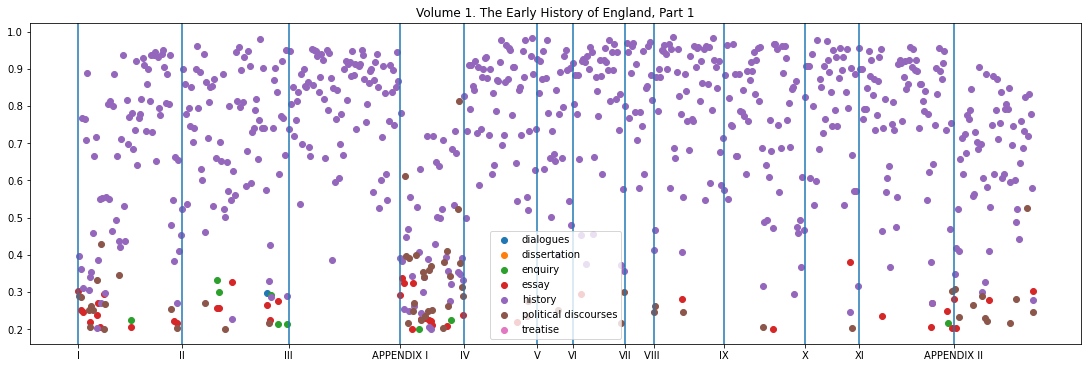

In [9]:
draw_volume(1, pred_logreg)

In [10]:
draw_volume(5, pred_logreg_nohist, n=6)

NameError: name 'pred_logreg_nohist' is not defined

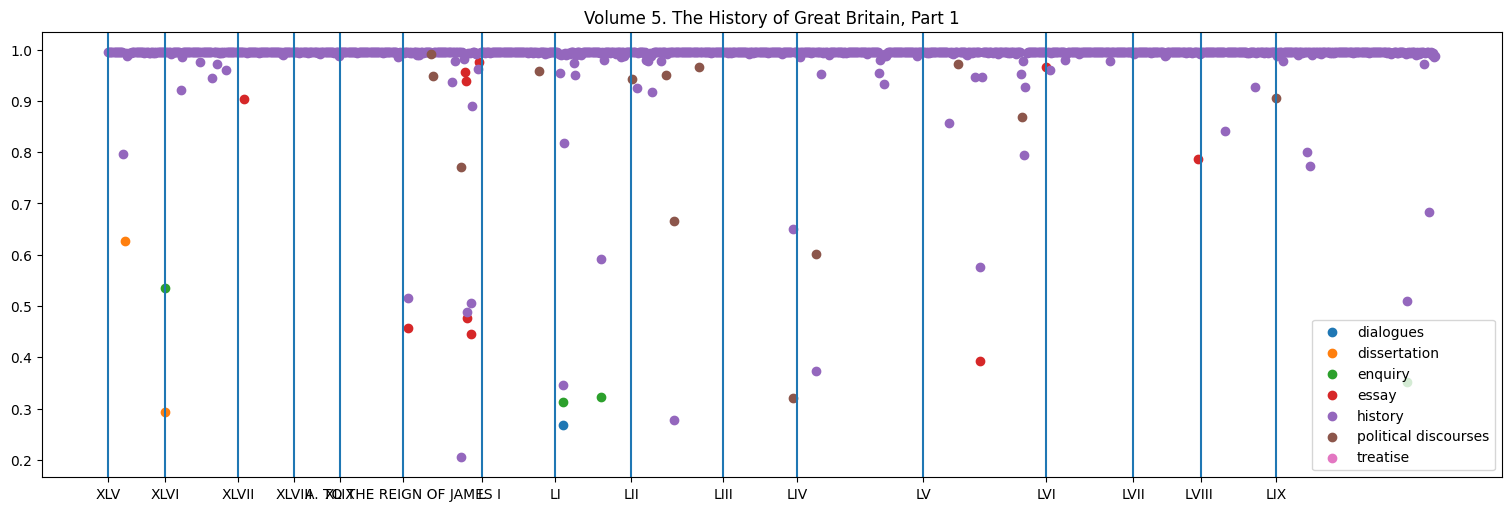

In [12]:
draw_volume(5, pred_transformer)

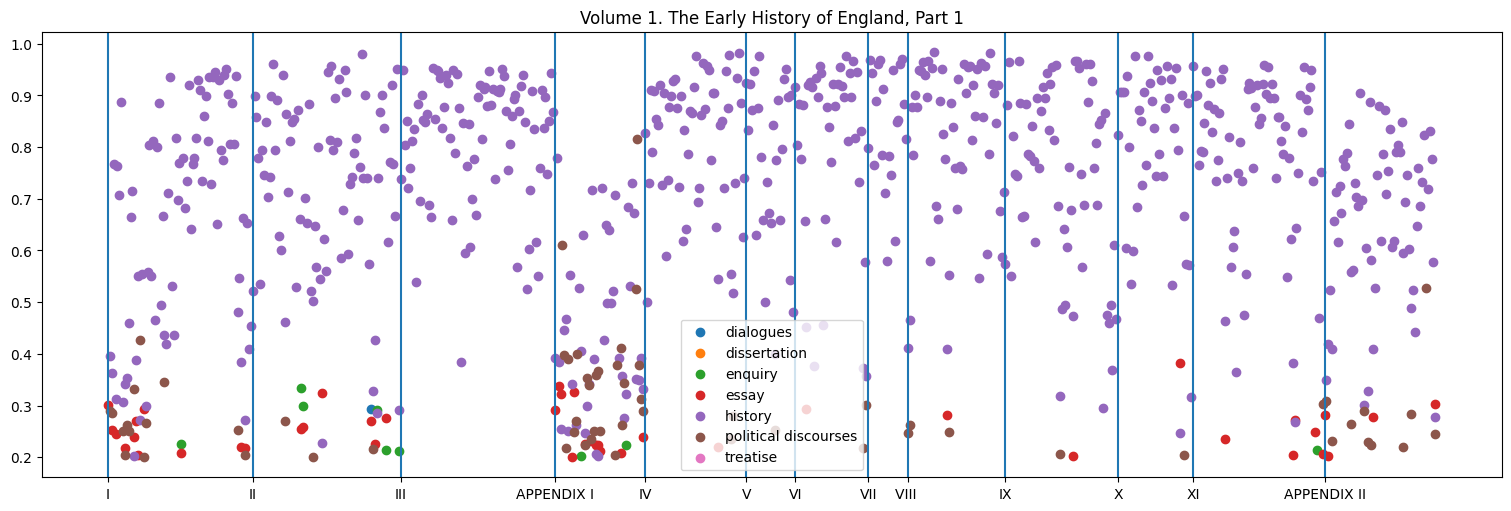

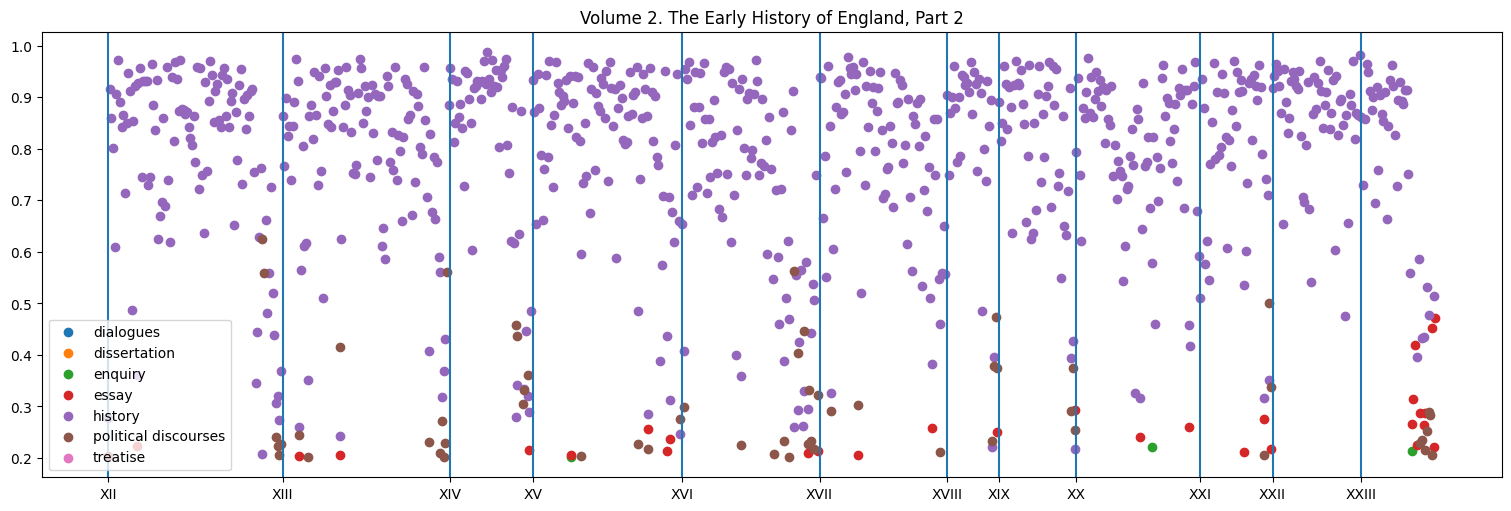

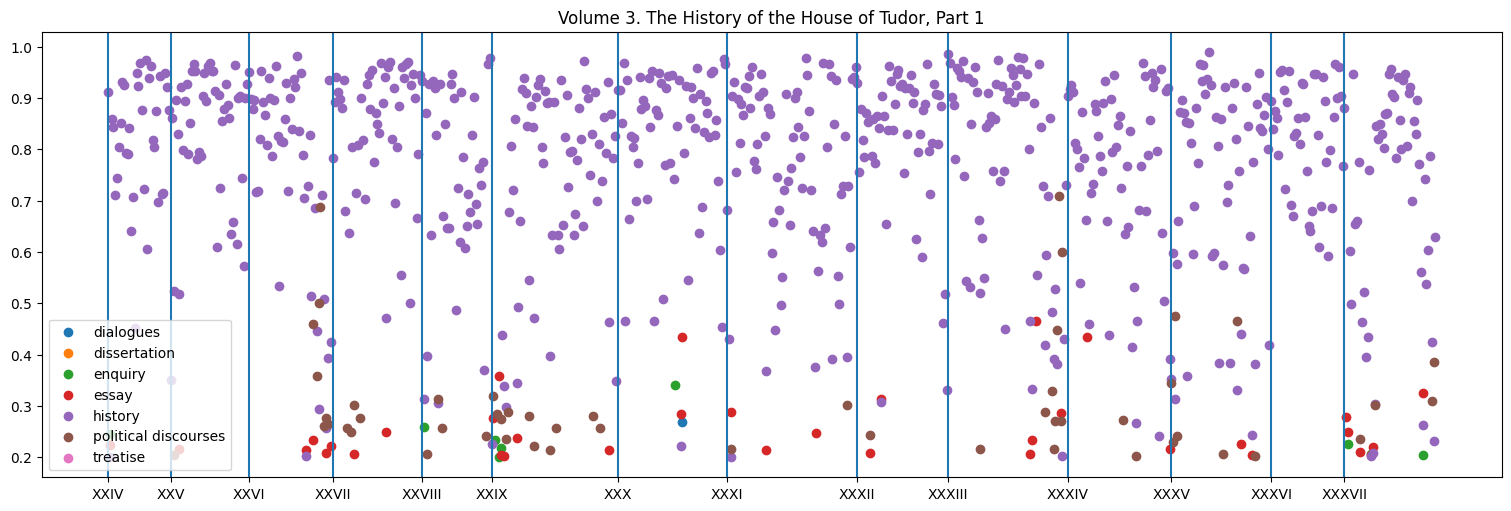

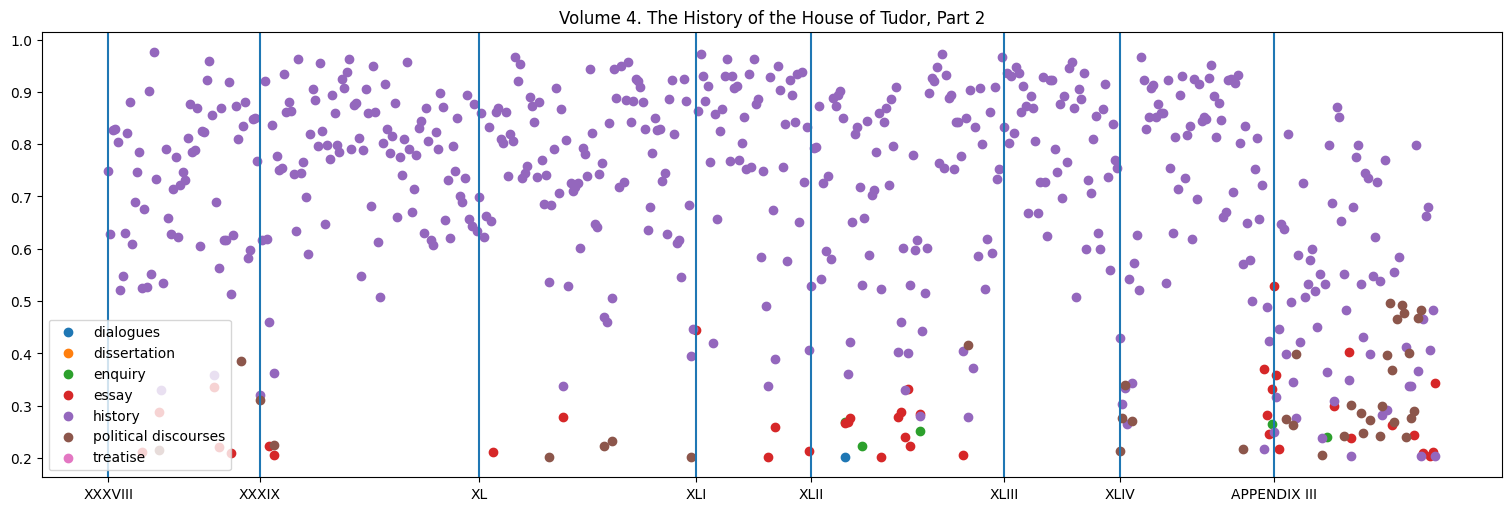

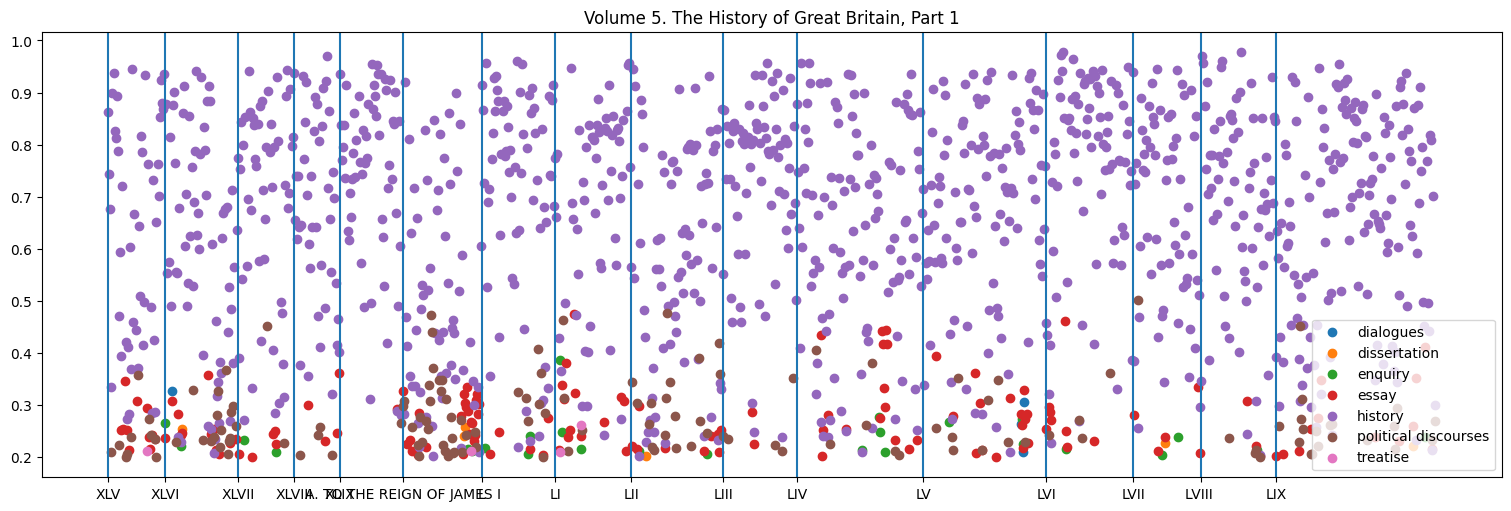

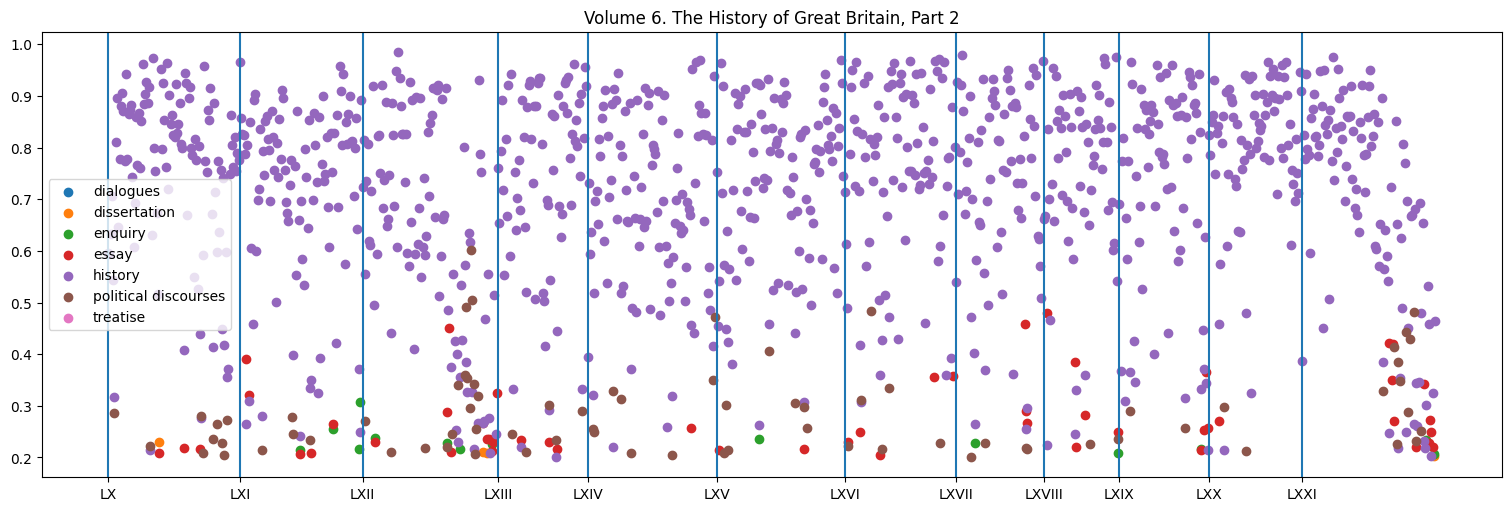

In [13]:
for i in range(1, 7):
    draw_volume(i, pred_logreg)

## Average chapter genre

Does not give us anything because the models predict history mostly

In [47]:
chapter_starts = [(key, value) for key, value in titles_inv.items()]
chapter_starts.append((5046, 'end'))

for i in range(len(chapter_starts)-1):
    chapter = chapter_starts[i]
    start = chapter[0]
    end = chapter_starts[i+1][0]
    genres = []
    for par in pred_logreg[start:end]:
        genre = par.argmax()
        genres.append(genre)
    print(chapter[1], '\t\t', id2label[max(set(genres), key=genres.count)])


I 		 history
II 		 history
III 		 history
APPENDIX I 		 history
IV 		 history
V 		 history
VI 		 history
VII 		 history
VIII  		 history
IX 		 history
X 		 history
XI 		 history
APPENDIX II 		 history
XII 		 history
XIII 		 history
XIV 		 history
XV 		 history
XVI 		 history
XVII 		 history
XVIII 		 history
XIX 		 history
XX 		 history
XXI 		 history
XXII 		 history
XXIII 		 history
XXIV 		 history
XXV 		 history
XXVI 		 history
XXVII 		 history
XXVIII 		 history
XXIX 		 history
XXX 		 history
XXXI 		 history
XXXII 		 history
XXXIII 		 history
XXXIV 		 history
XXXV 		 history
XXXVI 		 history
XXXVII 		 history
XXXVIII 		 history
XXXIX 		 history
XL 		 history
XLI 		 history
XLII 		 history
XLIII 		 history
XLIV 		 history
APPENDIX III 		 history
XLV 		 history
XLVI 		 history
XLVII 		 history
XLVIII 		 history
XLIX 		 history
A. TO THE REIGN OF JAMES I 		 history
L 		 history
LI 		 history
LII 		 history
LIII 		 history
LIV 		 history
LV 		 history
LVI 		 history
LVII 		 history
LVIII 

## Kleinberg experiments

In [11]:
# from burst_detection package

#This module creates definitions for implementing Kleinberg's burst detection analysis on batched data.

import pandas as pd
import numpy as np
from mpmath import log, binomial

#define the transition cost tau: cost of switching states
#there's a cost to move up states, no cost to move down
#based on definition on pg. 8
#inputs
#   i1: current state
#   i2: next state
#   gam: gamma, penalty for moving up a state
#   n: number of timepoints
def tau(i1,i2,gamma,n):
    if i1>=i2:
        return 0
    else: 
        return (i2-i1) * gamma * np.log(n)
    
#define the fit cost: goodness of fit to the expected outputs of each state
#based on equation on bottom of pg. 14
#    d: number of events in each time period (1xn)
#    r: number of target events in each time period (1xn)
#    p: expected proportions of each state (1xk)
def fit(d,r,p):
    return -float((log(binomial(int(d),r)) + r*np.log(p) + (d-r)*np.log(1-p)))

#define the burst detection function for a two-state automaton
#inputs:
#   r: number of target events in each time period (1xn)
#   d: number of events in each time period (1xn)
#   n: number of timepoints
#   s: multiplicative distance between states
#   gamma: difficulty to move up a state
#   smooth_win: width of smoothing window (use odd numbers)
#output:
#   q: optimal state sequence (1xn)
def burst_detection(r,d,n,s,gamma,smooth_win):
    
    k = 2 #two states
    
    #smooth the data if the smoothing window is greater than 1
    if smooth_win > 1:
        temp_p = r/d #calculate the proportions over time and smooth
        temp_p = temp_p.rolling(window=smooth_win, center=True).mean()
        #update r to reflect the smoothed proportions
        r = temp_p*d
        real_n = sum(~np.isnan(r))  #update the number of timepoints
    else: 
        real_n = n
          
    #calculate the expected proportions for states 0 and 1
    p = {}
    p[0] = np.nansum(r) / float(np.nansum(d))   #overall proportion of events, baseline state
    p[1] = p[0] * s                             #proportion of events during active state
    if p[1] > 1:                                #p1 can't be bigger than 1
        p[1] = 0.99999

    #initialize matrices to hold the costs and optimal state sequence
    cost = np.full([n,k],np.nan)
    q = np.full([n,1],np.nan)

    #use the Viterbi algorithm to find the optimal state sequence
    for t in range(int((smooth_win-1)/2),(int((smooth_win-1)/2))+real_n):

        #calculate the cost to transition to each state
        for j in range(k): 

            #for the first timepoint, assume we're coming from a baseline state
            if t == int((smooth_win-1)/2):
                cost[t,j] = tau(0,j,gamma,real_n) + fit(d[t],r[t],p[j])

            #for all other timepoints, calculate the fit and transition cost
            else:
                cost[t,j] = tau(q[t-1],j,gamma,real_n) + fit(d[t],r[t],p[j]) # !!!!!!!!!!!!!!!!

        #add the state with the minimum cost to the optimal state sequence
        q[t] = np.where(cost[t,:] == min(cost[t,:]))[0]

    return q, d, r, p

#define a function to enumerate the bursts
#input: 
#   q: optimal state sequence
#   label: name of burst
#output:
#   bursts: dataframe with beginning and end of each burst
def enumerate_bursts(q, label):
    bursts = pd.DataFrame(columns=['label','begin','end','weight'])
    
    #replace any NaNs with 0
    q = np.nan_to_num(q)
    
    #deal with bursts that extend beyond the time period
    starts = []; ends = []
    if q[0] == 1:
        starts = [0]
    if q[-1] == 1:
        ends = [len(q)-1]

    #find time points where a burst begins or ends
    diff = q[:-1] - q[1:]
    starts = np.hstack((starts,np.where(diff==-1)[0]+1))
    ends = np.hstack((np.where(diff==1)[0],ends))

    #fill in the burst dataframe
    bursts['begin'] = starts.astype('int')
    bursts['end'] = ends.astype('int')
    bursts['label'] = label
            
    return bursts

#define a function that finds the weights associated with each burst
#find the difference in the cost functions for p0 and p1 in each burst 
#inputs:
#   bursts: dataframe containing the beginning and end of each burst
#   r: number of target events in each time period
#   d: number of events in each time period
#   p: expected proportion for each state
#output:
#   bursts: dataframe containing the weights of each burst, in order
def burst_weights(bursts, r, d, p):
    
    #loop through bursts
    for b in range(len(bursts)):

        cost_diff_sum = 0

        for t in range(bursts.loc[b,'begin'], bursts.loc[b,'end']+1):

            cost_diff_sum = cost_diff_sum + (fit(d[t],r[t],p[0]) - fit(d[t],r[t],p[1]))

        bursts.loc[b,'weight'] = cost_diff_sum
        
    return bursts.sort_values(by='weight', ascending=False)


In [12]:
pred_logreg[:500]

array([[0.04136526, 0.16849113, 0.1886916 , ..., 0.06492982, 0.16438204,
        0.06932298],
       [0.01273049, 0.08676913, 0.03234732, ..., 0.39720446, 0.28923204,
        0.02120465],
       [0.0106045 , 0.03980345, 0.03804087, ..., 0.36130067, 0.28591425,
        0.01146057],
       ...,
       [0.00919355, 0.01875289, 0.02868951, ..., 0.87094842, 0.01631362,
        0.00709728],
       [0.00496763, 0.00980533, 0.00953964, ..., 0.91717281, 0.02435311,
        0.00336827],
       [0.00816593, 0.01303509, 0.01355224, ..., 0.8944731 , 0.04190195,
        0.00455504]])

In [156]:
def extract_bursts(volume, genre_id, pred):
    
    threshold = 0.15
    weight_threshold = 0.5
    
    
    # borders of the volume
    start = volume_start[volume][1] # starting paragraph
    end = volume_start[volume+1][1] # ending paragraph + 1
    
    target_events = [1 if line[genre_id] >= threshold else 0 for line in pred[start:end]]
    
    events = [1 for i in range(len(target_events))]
    
    #number of target events at each time point
    r = np.array(target_events, dtype=float)
    
    if not sum(r): # no target events
        return [], []
    
    #total number of events at each time point
    d = np.array(events, dtype=float)
    #number of time points
    n = len(r)

    #find the optimal state sequence (q)
    q, d, r, p = burst_detection(r, d, n, s=2, gamma=0.01, smooth_win=1)

    #enumerate bursts based on the optimal state sequence
    bursts = enumerate_bursts(q, 'burstLabel')

    #find weight of bursts
    weighted_bursts = burst_weights(bursts, r, d, p)
    
    res = weighted_bursts[weighted_bursts['weight'] >= weight_threshold]
    
    lefts = res['begin'].to_list()
    rights = res['end'].to_list()
    
    return lefts, rights

In [130]:
def draw_genre(volume, genre, pred=pred_logreg):
    
    genre_id = label2id[genre]
        
    lefts, rights = extract_bursts(volume, genre_id, pred)

    def draw_section(left, right):

        def f(t):
            return 1

        section = np.arange(left,right+1,1)
        plt.fill_between(section,f(section), alpha = 0.5, color=colors[genre])

    for l, r in zip(lefts, rights):
        draw_section(l, r)

In [133]:
def draw_volume(volume):
    n = 7 # number of genres

    volume = volume - 1 # volume number
    fig, ax = plt.subplots(figsize=(15, 5), layout='constrained')

    start = volume_start[volume][1] # starting paragraph
    end = volume_start[volume+1][1] # ending paragraph + 1

    x = np.array([i for i in range(len(pred[start:end]))]) # go through paragraphs
    for i in range(n):
        y = pred.T[i][start:end]
        y = [v if v > 0.05 else None for v in y]
        ax.scatter(x,y, label=id2label[i], color=colors[id2label[i]])

    ax.legend()
    plt.title(volume_names[volume])

    titles = [titles_inv[el] for el in titles_inv if el >= start and el < end]
    ticks = [el-start for el in titles_inv if el >= start and el < end]
    ax.xaxis.set_ticks(ticks, labels=titles, fontsize=10)

    # chapter borders
    for t in ticks:
        plt.axvline(x = t)
        
    for genre in label2id.keys():
        draw_genre(volume, genre)
        
    plt.show()

/tmp/ipykernel_910049/379919159.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost[t,j] = tau(q[t-1],j,gamma,real_n) + fit(d[t],r[t],p[j])
/tmp/ipykernel_910049/379919159.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost[t,j] = tau(q[t-1],j,gamma,real_n) + fit(d[t],r[t],p[j])
/tmp/ipykernel_910049/379919159.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost[t,j] = tau(q[t-1],j,gamma,real_n) + fit(d[t],r[t],p[j])
/tmp/ipykernel_910049/379919159

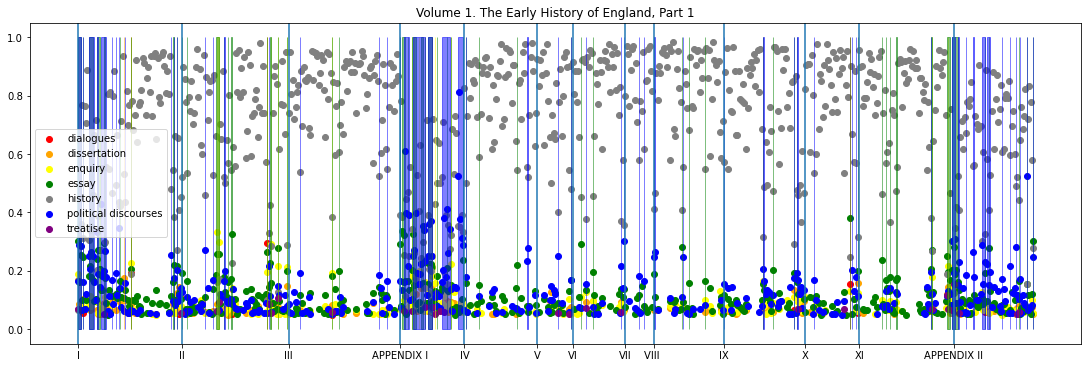

/tmp/ipykernel_910049/379919159.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost[t,j] = tau(q[t-1],j,gamma,real_n) + fit(d[t],r[t],p[j])
/tmp/ipykernel_910049/379919159.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost[t,j] = tau(q[t-1],j,gamma,real_n) + fit(d[t],r[t],p[j])
/tmp/ipykernel_910049/379919159.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost[t,j] = tau(q[t-1],j,gamma,real_n) + fit(d[t],r[t],p[j])
/tmp/ipykernel_910049/379919159

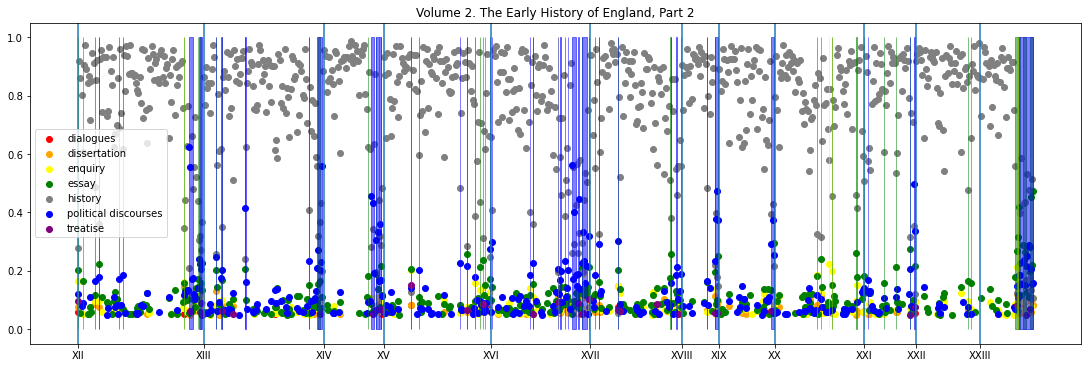

/tmp/ipykernel_910049/379919159.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost[t,j] = tau(q[t-1],j,gamma,real_n) + fit(d[t],r[t],p[j])
/tmp/ipykernel_910049/379919159.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost[t,j] = tau(q[t-1],j,gamma,real_n) + fit(d[t],r[t],p[j])
/tmp/ipykernel_910049/379919159.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost[t,j] = tau(q[t-1],j,gamma,real_n) + fit(d[t],r[t],p[j])
/tmp/ipykernel_910049/379919159

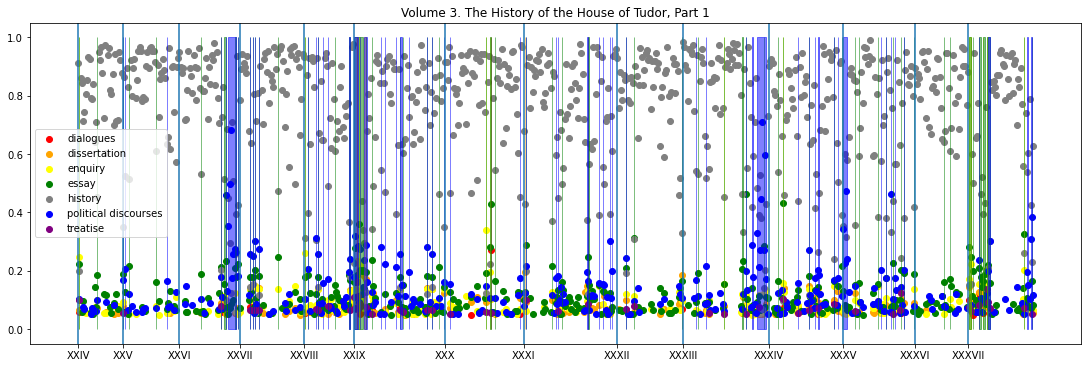

/tmp/ipykernel_910049/379919159.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost[t,j] = tau(q[t-1],j,gamma,real_n) + fit(d[t],r[t],p[j])
/tmp/ipykernel_910049/379919159.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost[t,j] = tau(q[t-1],j,gamma,real_n) + fit(d[t],r[t],p[j])
/tmp/ipykernel_910049/379919159.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost[t,j] = tau(q[t-1],j,gamma,real_n) + fit(d[t],r[t],p[j])
/tmp/ipykernel_910049/379919159

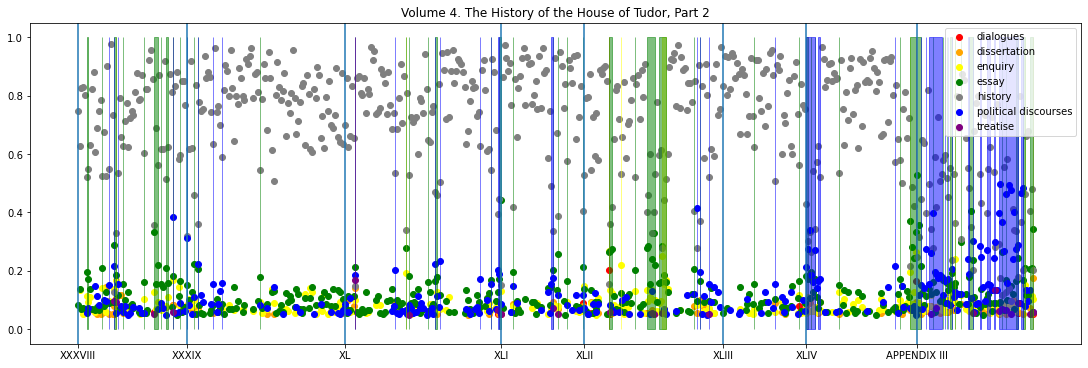

/tmp/ipykernel_910049/379919159.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost[t,j] = tau(q[t-1],j,gamma,real_n) + fit(d[t],r[t],p[j])
/tmp/ipykernel_910049/379919159.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost[t,j] = tau(q[t-1],j,gamma,real_n) + fit(d[t],r[t],p[j])
/tmp/ipykernel_910049/379919159.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost[t,j] = tau(q[t-1],j,gamma,real_n) + fit(d[t],r[t],p[j])
/tmp/ipykernel_910049/379919159

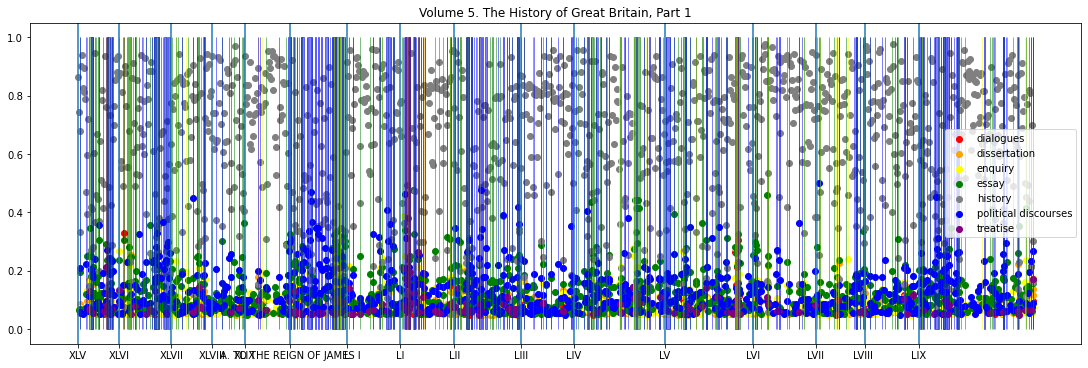

/tmp/ipykernel_910049/379919159.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost[t,j] = tau(q[t-1],j,gamma,real_n) + fit(d[t],r[t],p[j])
/tmp/ipykernel_910049/379919159.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost[t,j] = tau(q[t-1],j,gamma,real_n) + fit(d[t],r[t],p[j])
/tmp/ipykernel_910049/379919159.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost[t,j] = tau(q[t-1],j,gamma,real_n) + fit(d[t],r[t],p[j])
/tmp/ipykernel_910049/379919159

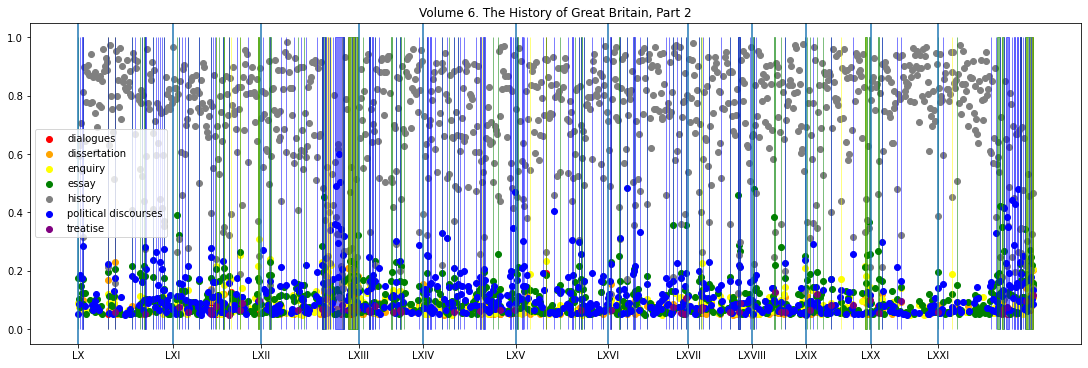

In [160]:
for i in range(1, 7):
    draw_volume(i)